In [214]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install lazypredict bayesian-optimization hyperopt scipy

     |████████████████████████████████| 965 kB 9.5 MB/s eta 0:00:01
  Using cached future-0.18.2-py3-none-any.whl
     |████████████████████████████████| 1.6 MB 15.7 MB/s eta 0:00:01
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
You should consider upgrading via the '/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/bin/python3 -m pip install --upgrade pip' command.


In [35]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np 

## Load Data 

In [138]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from functools import reduce

def alpha_vantage_data(symbol, interval):
    apiKey = 'IOLIXAXKGPI3A4QM'

    ts = TimeSeries(key = apiKey, output_format = 'csv')

    data_frames = []

    #download the csv
    month_one = ts.get_intraday_extended(symbol = symbol , interval = interval , slice ='year1month1')
    one = pd.DataFrame(list(month_one[0]))
    data_frames.append(one)

    month_two = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month2')
    month_two = pd.DataFrame(list(month_two[0]))
    data_frames.append(month_two)
    
    month_three = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month3')
    month_three = pd.DataFrame(list(month_three[0]))
    data_frames.append(month_three)
    
    month_four = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month4')
    month_four = pd.DataFrame(list(month_four[0]))
    data_frames.append(month_four)
    
    month_five = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month5')
    month_five = pd.DataFrame(list(month_five[0]))
    data_frames.append(month_five)
    
#     month_six = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month6')
#     month_six = pd.DataFrame(list(month_six[0]))
#     data_frames.append(month_six)
    
#     month_seven = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month7')
#     month_seven = pd.DataFrame(list(month_seven[0]))
#     data_frames.append(month_seven)
    
    
#     month_eight = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month8')
#     month_eight = pd.DataFrame(list(month_eight[0]))
#     data_frames.append(month_eight)

#     month_nine = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month9')
#     month_nine = pd.DataFrame(list(month_nine[0]))
#     data_frames.append(month_nine)
    
#     month_ten = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month10')
#     month_ten = pd.DataFrame(list(month_ten[0]))
#     data_frames.append(month_ten)
    
#     month_eleven = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month11')
#     month_eleven = pd.DataFrame(list(month_eleven[0]))
#     data_frames.append(month_eleven) 
    
#     month_twelve = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month12')
#     month_twelve = pd.DataFrame(list(month_twelve[0]))
#     data_frames.append(month_twelve)
    
    df = pd.concat(data_frames)
    
#     #df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'], how='outer'), data_frames).fillna('void')

    #csv --> dataframe
#     df = pd.DataFrame(list(df_merged[0]))

    # print(df)

    #setup of column and index
    header_row=0
    df.columns = df.iloc[header_row]
    df = df.drop(header_row)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df = df.drop_duplicates()

    #show output
    return df 

In [139]:
df = alpha_vantage_data('PLTR', '15min')

df = df.apply(pd.to_numeric)

df['adjclose'] = df['close']

df.tail()
## combine dataframes 

,open,high,low,close,volume,adjclose
time,,,,,,
2020-12-14 05:15:00,27.81,27.93,27.81,27.92,3402,27.92
2020-12-14 05:00:00,27.84,27.96,27.80,27.81,10669,27.81
2020-12-14 04:45:00,27.77,27.85,27.75,27.83,8862,27.83
2020-12-14 04:30:00,27.73,27.84,27.71,27.76,12888,27.76
2020-12-14 04:15:00,27.48,27.80,27.31,27.71,15174,27.71


## Feature Engineering 


We will now create certain features from the pricing data which would include:
1. SMA_20 : Simple Moving Average of 20 day window
2. Std_dev : Standard Deviation for 20 day window
3. Band_1 : Bollinger band created using SMA_20 + Std_dev
4. Band_2 : Bollinger band created using SMA_20 - Std_dev
5. ON_returns : whether there was up or down move from prior day closing price to current day opening price
6. dist_from_mean : How much distant stock prices are from the mean
7. vix_data: CBOE Volatility index price from the prior day

In [140]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.high + data.low + data.close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

In [141]:
from backtesting.test import EURUSD, SMA

def get_clean_data (df):
    '''This function takes the historical OHLC data and return features as we defined above
    
    Parameters
    ----------
    df : DataFrame
        Dataframe containing pricing data
    start_date : str, optional
        Takes start date of data for vix, format = 'yyyy-mm-dd'
    end_date : str, optional
        Takes ebd date of data for vix, format = 'yyyy-mm-dd'
        
    Returns
    -------
    pandas DataFrame containing scaled features except categorical features
    '''
    
    features = df.copy()
    # Some datetime features for good measure
    features['X_day'] = features.index.dayofweek
    features['X_hour'] = features.index.hour
#     features = features.drop(['formatted_date'], axis=1)
    #creating features as stated above
    features['volume'] = features['volume'].shift(1)
    close = features.close.values
    sma10 = SMA(features.close, 10)
    sma20 = SMA(features.close, 20)
    sma50 = SMA(features.close, 50)
    sma100 = SMA(features.close, 100)
    upper, lower = BBANDS(features, 20, 2)
#     upper, lower = BBANDS(features, 20, 2)

    # Design matrix / independent features:

    # Price-derived features
    features['X_SMA10'] = (close - sma10) / close
    features['X_SMA20'] = (close - sma20) / close
    features['X_SMA50'] = (close - sma50) / close
    features['X_SMA100'] = (close - sma100) / close

    features['X_DELTA_SMA10'] = (sma10 - sma20) / close
    features['X_DELTA_SMA20'] = (sma20 - sma50) / close
    features['X_DELTA_SMA50'] = (sma50 - sma100) / close

    # Indicator features
    features['X_MOM'] = features.close.pct_change(periods=2)
    features['X_BB_upper'] = (upper - close) / close
    features['X_BB_lower'] = (lower - close) / close
    features['X_BB_width'] = (upper - lower) / close
    
    
    features['SMA'] = features['adjclose'].rolling(window=20).mean().shift(1)
    features['Std_20'] = features['adjclose'].rolling(window=20).std().shift(1)
    features['Band_1'] = features['SMA'] - features['Std_20']
    features['Band_2'] = features['SMA'] + features['Std_20']
    features['ON_returns'] = features['close'] - features['open'].shift(-1)
    features['ON_returns'] = features['ON_returns'].shift(1)
    features['ON_returns_signal'] = np.where(features['ON_returns']<0, 'up', 'down')
    features['dist_from_mean'] = features['adjclose'].shift(1) - features['X_SMA10']
    
#     print('features\n', features.head())
    
#     #Obtaining Vix Data and combining with existing features of stock
#     ticker = ['^VIX']
#     start_date = start_date
#     end_date = end_date
#     vix_data, ticker_not_found = get_stock_data(ticker, start_date, end_date)
#     vix_data = pd.DataFrame(vix_data['adjclose'].shift(1))
#     vix_data = vix_data.rename(columns = {'adjclose':'vix_data'})
#     comb_features = pd.concat([features,vix_data], axis=1)
#     comb_features = comb_features.dropna() #dropping NaN values
    comb_features = pd.get_dummies(features, columns=['ON_returns_signal']) #for categorical variables
    comb_features = comb_features.drop('ON_returns', axis=1) #dropping original categorical column
    comb_features = comb_features.drop('close', axis=1) #not really needed this value since we have adj close now
    ###Create return column to predict
    comb_features['stock_move'] = np.where(comb_features['adjclose']-
                                           comb_features['adjclose'].shift(-1)<0, "Buy", "Sell")
    features_clean = comb_features.dropna() #Dropping Nan values
    features_clean = features_clean[:-1] #Drop last row which do not have any stock signal
    features_clean.tail()
    return features_clean

In [142]:
features = get_clean_data(df)



In [143]:
## Drop Unnecessary Values
features.drop(['ON_returns_signal_down','ON_returns_signal_up'], axis=1, inplace=True)

In [144]:
features.head()

,open,high,low,volume,adjclose,X_day,X_hour,X_SMA10,X_SMA20,X_SMA50,...,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,SMA,Std_20,Band_1,Band_2,dist_from_mean,stock_move
time,,,,,,,,,,,,,,,,,,,,,
2021-05-11 11:15:00,19.27,19.69,19.21,9620016.00,19.69,1,11,-0.01,-0.01,-0.03,...,-0.00,0.03,-0.00,0.03,19.96,0.17,19.79,20.12,20.01,Sell
2021-05-11 11:00:00,19.04,19.41,18.83,6940105.00,19.28,1,11,-0.03,-0.03,-0.05,...,-0.04,0.05,0.01,0.04,19.93,0.17,19.76,20.10,19.72,Sell
2021-05-11 10:45:00,18.98,19.16,18.81,6641313.00,19.04,1,10,-0.04,-0.04,-0.06,...,-0.03,0.07,0.01,0.06,19.89,0.21,19.67,20.10,19.32,Sell
2021-05-11 10:30:00,19.39,19.82,18.96,10089844.00,18.97,1,10,-0.04,-0.04,-0.07,...,-0.02,0.07,0.01,0.06,19.83,0.27,19.56,20.10,19.07,Buy
2021-05-11 10:15:00,19.46,19.56,19.04,13080826.00,19.39,1,10,-0.01,-0.02,-0.04,...,0.02,0.05,-0.01,0.06,19.77,0.32,19.45,20.09,18.98,Buy


## Data Scaling on train and test 

In [145]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.adjclose.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

### Label Encoder

In [146]:
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
features['stock_move'] = labelencoder.fit_transform(features['stock_move']) 

In [186]:


np.random.seed(60)

X = features.drop(['stock_move'], axis=1)
y = features['stock_move']

# X, y = get_clean_Xy(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)


### Scale Data 

In [187]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

robust = RobustScaler()

X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)
#Scale the features
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



## Instantiate & Create Classifier

In [188]:
# LazyClassifier Instance and fiting data
cls= LazyClassifier(ignore_warnings=False, custom_metric=None)
models = cls.fit(X_train, X_test, y_train, y_test)

 21%|██        | 6/29 [00:01<00:05,  4.16it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 97%|█████████▋| 28/29 [00:06<00:00,  5.22it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 29/29 [00:06<00:00,  4.47it/s]


In [189]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.83,0.69,None,0.82,0.35
RandomForestClassifier,0.77,0.61,None,0.76,0.74
LGBMClassifier,0.77,0.60,None,0.76,0.34
BaggingClassifier,0.74,0.59,None,0.73,0.26
XGBClassifier,0.76,0.59,None,0.75,0.36
DecisionTreeClassifier,0.70,0.59,None,0.70,0.05
KNeighborsClassifier,0.71,0.58,None,0.71,0.19
ExtraTreeClassifier,0.68,0.57,None,0.68,0.02
LabelSpreading,0.53,0.49,None,0.41,0.42


In [191]:
print(models)

(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
CalibratedClassifierCV             0.89               0.89     0.89      0.89   
LinearSVC                          0.89               0.89     0.89      0.89   
LinearDiscriminantAnalysis         0.85               0.84     0.84      0.85   
RidgeClassifierCV                  0.85               0.84     0.84      0.84   
RidgeClassifier                    0.83               0.83     0.83      0.83   
LogisticRegression                 0.81               0.81     0.81      0.81   
SGDClassifier                      0.77               0.78     0.78      0.77   
PassiveAggressiveClassifier        0.75               0.76     0.76      0.75   
NuSVC                              0.76               0.75     0.75      0.76   
LGBMClassifier                     0.70               0.70     0.70      0.70   
XGBClassifier              

In [192]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rfc = RandomForestClassifier()


etc = ExtraTreesClassifier()


## KFold Cross Validation 

In [193]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

In [194]:
kf5 = KFold(n_splits=5, shuffle=False)
kf3 = KFold(n_splits=3, shuffle=False)

In [195]:
feats = features.drop('stock_move', axis=1)
feats.head(1)

,open,high,low,volume,adjclose,X_day,X_hour,X_SMA10,X_SMA20,X_SMA50,...,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,SMA,Std_20,Band_1,Band_2,dist_from_mean
time,,,,,,,,,,,,,,,,,,,,,
2021-05-11 11:15:00,19.27,19.69,19.21,9620016.00,19.69,1,11,-0.01,-0.01,-0.03,...,0.03,-0.00,0.03,-0.00,0.03,19.96,0.17,19.79,20.12,20.01


In [196]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(etc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print(np.max(scores), np.std(scores))

0.5727554179566563 0.03544004080537092


## Hyperperamater Tuning 

In [203]:
# !pip install bayes_opt

In [204]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from bayes_opt import BayesianOptimization

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Different RandomForestClassifier hyperparameters
etc_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}




In [205]:
etc = RandomizedSearchCV(ExtraTreesClassifier(),
                           param_distributions=etc_grid,
                           cv=5,
                           n_iter=50,
                           verbose=True,
                           n_jobs=-1
                        )

# accuracy ={}
# for i in range(1,300):
#     classifier = RandomForestClassifier(n_estimators=i, random_state=15)
#     classifier.fit(X_train, y_train)
#     y_pred_ev = classifier.predict(X_test)
#     accuracy[i] = accuracy_score(y_test, y_pred_ev)

# Fit random hyperparameter search model
etc.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   26.0s finished


In [206]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rfc = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=50,
                           verbose=True,
                           n_jobs=-1)

# accuracy ={}
# for i in range(1,300):
#     classifier = RandomForestClassifier(n_estimators=i, random_state=15)
#     classifier.fit(X_train, y_train)
#     y_pred_ev = classifier.predict(X_test)
#     accuracy[i] = accuracy_score(y_test, y_pred_ev)

# Fit random hyperparameter search model
rfc.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.2min finished


In [207]:
# check best params 

etc.best_params_

{'n_estimators': 760,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [208]:
rfc.best_params_

{'n_estimators': 460,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_depth': None}

## Bayesian Optimization 

In [250]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score

## Create Trials 

In [271]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#General function for building a model
def rf_cv(X, y, **kwargs):
    estimator = RandomForestClassifier(**kwargs)
    cval = cross_val_score(etc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return cval.mean()


def bayesian_optimise_rf(X, y, n_iter = 100):
    def rf_crossval(n_estimators, max_features):
        #Wrapper of RandomForest cross validation.
        #Note the fixing of the inputs so they match the expected type
        #(e.g n_estimators must be an integer)
        return rf_cv(
            X = X,
            y = y,
            n_estimators = int(n_estimators),
            max_features = max(min(max_features, 0.999), 1e-3),
            bootstrap = True
        )
    
    optimizer = BayesianOptimization(
        f = rf_crossval,
        pbounds = {
            "n_estimators" : (10, 400),
            "max_features" : (0.1, 0.999),
        }
    )
    optimizer.maximize(n_iter = n_iter)
    print("Final result:", optimizer.max)

In [ ]:
%%time 
bo_rf = bayesian_optimise_rf(X_train, y_train)

|   iter    |  target   | max_fe... | n_esti... |
-------------------------------------------------
|  1        |  0.5334   |  0.9294   |  213.3    |
|  2        |  0.5287   |  0.6275   |  181.0    |
|  3        |  0.5325   |  0.1138   |  159.9    |
|  4        |  0.5352   |  0.8867   |  302.8    |
|  5        |  0.5303   |  0.9203   |  195.5    |
|  6        |  0.5334   |  0.5779   |  303.9    |
|  7        |  0.5309   |  0.7984   |  301.3    |
|  8        |  0.5371   |  0.1829   |  302.9    |
|  9        |  0.5278   |  0.2132   |  302.4    |
|  10       |  0.5328   |  0.4009   |  106.9    |
|  11       |  0.534    |  0.6586   |  242.0    |
|  12       |  0.5334   |  0.6102   |  105.9    |
|  13       |  0.5294   |  0.68     |  251.5    |
|  14       |  0.5244   |  0.2598   |  220.7    |
|  15       |  0.5284   |  0.4977   |  31.83    |
|  16       |  0.5269   |  0.2882   |  117.0    |
|  17       |  0.5337   |  0.2186   |  131.7    |
|  18       |  0.5334   |  0.2591   |  96.28    |


## Score tuned models 

In [209]:
# randomized search random forest model
rfc.score(X_test, y_test)

0.5523956723338486

In [210]:
# randomized search random forest model
etc.score(X_test, y_test)

0.5465224111282844

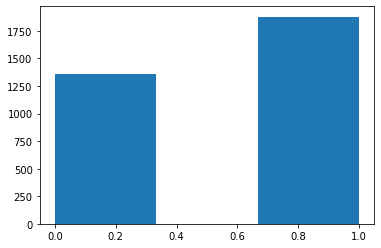

In [211]:
import matplotlib.pyplot as plt 

y_pred = rfc.predict(X_test)
plt.hist(y_pred, bins=3);

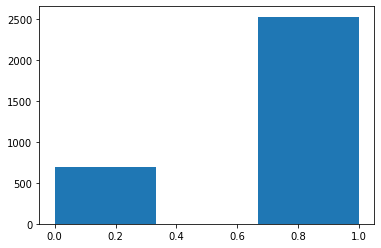

In [212]:
y_pred = etc.predict(X_test)
plt.hist(y_pred, bins=3);

Accuracy score of the model is:  0.5465224111282844


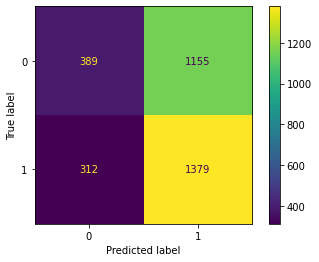

In [213]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix


print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(etc, X_test, y_test);


### Save hyperparameter Models 

In [ ]:
# Serialize Optimized Random Forest 
import pickle 
pickle.dump(etc, open('optimized-etc-82', 'wb'))

